In [1]:
import os
import time
import glob
import gdown
import torch
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import shutil
from PIL import Image

#libraries for yolo
from pytorchyolo.models import load_model
from pytorchyolo.utils.transforms import Resize, DEFAULT_TRANSFORMS
from pytorchyolo.utils.utils import non_max_suppression

In [2]:
def download_weights():
    model_file=[
        'yolo_face_sthanhng.weights',
        'yolo_face_sthanhng.cfg'
    ]
    
    gdrive_url=[
        'https://drive.google.com/uc?id=1utquM5TAnfIa1Aq0X9fCvrllHiTWazdD',
        'https://drive.google.com/uc?id=1CPUZlYL5ik4d9y6oCyzi0930KgzawI6V'
    ]
    
    cwd=os.getcwd() 
    if 'weights' in os.listdir(cwd):
        for i in range(len(model_file)):
            if model_file[i] in os.listdir(os.path.join(cwd, 'weights')):
                print(model_file[i] + ':: status : file already exists')
            else:
                gdown.download(gdrive_url[i],os.path.join(cwd, 'weights', model_file[i]), quiet=False)
    else:
        os.makedirs(os.path.join(cwd,'weights'))
        for i in range(len(model_file)):
            gdown.download(gdrive_url[i], os.path.join(cwd, 'weights', model_file[i]), quiet=False)  

In [3]:
# download the necessary weights for YOLO-Face
download_weights()

yolo_face_sthanhng.weights:: status : file already exists
yolo_face_sthanhng.cfg:: status : file already exists


import sys
import os
import torch
import torchvision
import numpy as np
import pandas as pd
sys.path.append('src_release')## YOLOFace with FGSM

# YOLO Implementation

In [4]:
# Patterned after FGSM tutorial (https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)
# Define what device we are using
print("CUDA Available: ", torch.cuda.is_available())
device, model = load_model('./weights/yolo_face_sthanhng.cfg', "./weights/yolo_face_sthanhng.weights")

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  False


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [5]:
def detach_cpu(image):
    return image.detach().cpu()

# convert 1x3x416x416 to 416x416x3
def reshape_image(image):
    return np.transpose(np.squeeze(image), (1 ,2, 0))

# convert 1x3x416x416 tensor to 416x416x3 numpy image
def tensor_to_image(image):
    return np.transpose(image.detach().cpu().squeeze().numpy(), (1, 2, 0))


In [6]:
#TODO: update the paths as needed

FOLDER_PATH = os.path.join(os.getcwd(), 'images')
BBOX_PATH = os.path.join(os.getcwd(), 'images_box')
PAD_PATH = os.path.join(os.getcwd(), 'images_pad')
ORIG_PAD_PATH = os.path.join(os.getcwd(), 'images_orig_pad')
PROCESS_PATH = os.path.join(os.getcwd(), 'images_process')
CSV_PATH = os.path.join(os.getcwd(), 'images_csv')

if not os.path.exists(BBOX_PATH):
    os.mkdir(BBOX_PATH)

if not os.path.exists(PAD_PATH):
    os.mkdir(PAD_PATH)
    
if not os.path.exists(ORIG_PAD_PATH):
    os.mkdir(ORIG_PAD_PATH)
    
if not os.path.exists(PROCESS_PATH):
    os.mkdir(PROCESS_PATH)

if not os.path.exists(CSV_PATH):
    os.mkdir(CSV_PATH)
    
def pipeline(model, device):
    
    df = pd.DataFrame() # dataframe storing the dataset
    row = {} #the information/columns for a single row in the dataset is stored here
    
    # Loop over all examples in test set
    for path in glob.glob(os.path.join(FOLDER_PATH, '*.jpg')):
        
        # GET THE FILENAME
        filename = os.path.basename(path)
        filename = filename.split(".")[0]
        print(filename)
        
        # INITIALIZE A FACE COUNTER
        face_count = 0
        
        row['path'] = path
        row['source_file'] = path.split("\\")[-1]
        print(path)
        print(row['source_file'])
        
        # read and transform the image from the path
        data = cv2.imread(path)  # read the image
        data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB) #change to rgb
        data = transforms.Compose([DEFAULT_TRANSFORMS,Resize(416)])((data, np.zeros((1, 5))))[0].unsqueeze(0) # transform the image
        
        # Forward pass the data through the model
        output = model(data)
        
        # call non max suppression
        nms, nms_output = non_max_suppression(output, 0.5, 0.5) #conf_thres and iou_thres = 0.5
        
        # loop through each of the faces in the image
        for face_index, face_row in enumerate(nms_output[0]): #nms_output[0] because the model is designed to take in several images at a time from the dataloader but we are only loading the image one at a time
            # FACE_FILENAME
            face_filename = filename + "_" + str(face_count)
            row['face_index'] = face_index
            print('Face ', face_index)
            
            # get the coordinate of the face bounding box
            #(x1, y1) upper left, (x2, y2) lower right
            x, y, w, h = face_row[0], face_row[1], face_row[2], face_row[3]
            
            # cropped image with bounding box
            # getting (x1, y1) upper left, (x2, y2) lower right
            x1 = int(np.floor((x - w / 2).detach().cpu().numpy()))
            y1 = int(np.floor((y - h / 2).detach().cpu().numpy()))
            x2 = int(np.ceil((x + w / 2).detach().cpu().numpy()))
            y2 = int(np.ceil((y + h / 2).detach().cpu().numpy()))
            
            row['x1'], row['y1'], row['x2'], row['y2'] = x1, y1, x2, y2
            
            print('Cropped')
            print(x1, y1, x2, y2)
            
            bbox_image = detach_cpu(data)[:, :, y1:y2, x1:x2] #get the first dimension, the channels, and crop it
            bbox_image = tensor_to_image(bbox_image) #reshape the image to (w/h, h/w, channel)
            bbox_image = np.transpose(transforms.Compose([DEFAULT_TRANSFORMS,Resize(128)])((bbox_image, np.zeros((1, 5))))[0], (1, 2, 0)).numpy() # resize image to 128x128
            bbox_image = (bbox_image * 255).astype(np.uint8)
            plt.imshow(bbox_image)
            plt.show()
            
            bbox_image = cv2.cvtColor(bbox_image, cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(BBOX_PATH, row['source_file'] + str(face_index) + '.jpg'), bbox_image)
            
            # getting (x1, y1) upper left, (x2, y2) lower right
             # cropped image with bounding box + some padding
            x1_pad = max(int(np.floor((x - w).detach().cpu().numpy())), 0) # prevent negative values
            y1_pad = max(int(np.floor((y - h).detach().cpu().numpy())), 0)
            x2_pad = min(int(np.ceil((x + w).detach().cpu().numpy())), 415) # prevent from getting out of range
            y2_pad = min(int(np.ceil((y + h).detach().cpu().numpy())), 415)
            
            row['x1_pad'], row['y1_pad'], row['x2_pad'], row['y2_pad'] = x1_pad, y1_pad, x2_pad, y2_pad
            
            pad_image = detach_cpu(data)[:, :, y1_pad:y2_pad, x1_pad:x2_pad] #get the first dimension, the channels, and crop it
            pad_image = tensor_to_image(pad_image) #reshape the image to (w/h, h/w, channel)
            
            # Original Pad Size
            # GET THE LONGEST MAX AND THEN PAD
            greater_size = max((x2_pad - x1_pad),(y2_pad - y1_pad))
            orig_pad_image = np.transpose(transforms.Compose([DEFAULT_TRANSFORMS,Resize(greater_size)])((pad_image, np.zeros((1, 5))))[0], (1, 2, 0)).numpy() # resize image to GREATER SIZE
            orig_pad_image = (orig_pad_image * 255).astype(np.uint8)
            orig_pad_image = cv2.cvtColor(orig_pad_image, cv2.COLOR_RGB2BGR)         
            cv2.imwrite(os.path.join(ORIG_PAD_PATH, "mask_" + face_filename + "_image_final.png"), orig_pad_image)
            
            pad_image = np.transpose(transforms.Compose([DEFAULT_TRANSFORMS,Resize(128)])((pad_image, np.zeros((1, 5))))[0], (1, 2, 0)).numpy() # resize image to 128x128
            pad_image = (pad_image * 255).astype(np.uint8)
            plt.imshow(pad_image)
            plt.show()
            
            # SAVE THE ORIGINAL NAME OF THE IMAGE FIRST.... AND THEN FOR EACH FACE APPEND THE FACE COUNTER            
            face_count += 1
            
            # ADD TO ROW FACE_FILENAME
            row['mask_filename'] = "mask_" + face_filename + "_image_final.png"
            
            # SAVE AS 24-BIT PNG WITH THE FORMAT OF IMAGEFILENAME_NO STUFF AND SUFFIX
            im = Image.fromarray(pad_image)
            im.save(PROCESS_PATH + "\\" +  face_filename + "_image_final.png")
            
            # [DUPLICATE WITH THE BLACK.PNG]            
            # Create the black _cc_occ_labels and _sp_labels (16 bit pngs)
            cc_occ_png = PROCESS_PATH + "\\" +  face_filename + "_cc_occ_labels.png"
            sp_png = PROCESS_PATH + "\\" +  face_filename + "_sp_labels.png"
            mask_png = PROCESS_PATH + '\\' + face_filename + "_mask.png"
            
            # black.png is reference image being duplicated
            shutil.copyfile("black.png", (cc_occ_png))
            shutil.copyfile("black.png", (sp_png))    
            
            pad_image = cv2.cvtColor(pad_image, cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(PAD_PATH, row['source_file'] + str(face_index) + '.jpg'), pad_image)
            
            #add tow to dataset
            df = df.append(row, ignore_index=True) #append the attributes of one face to the dataframe                              
    df.to_csv(os.path.join(CSV_PATH, 'dataset' + str(int(time.time())) + '.csv'), index=False)  #save to csv

# FaceSeg Implementation

In [7]:
import sys
import os
import torch
import torchvision
import numpy as np
import pandas as pd
sys.path.append('src_release')

#libraries for face segmentation
from data_loader import get_dataloader
from models.encoder_decoder_faceoccnet import FaceOccNet 
from torch_utils import torch_load_weights,evaluation,viz_notebook,plot_confusion_matrix

In [8]:
load_model_path = ("./ptlabel_best_model.pth")
eval_path = '.\\images_process'
fs_model = FaceOccNet(input_channels=3, n_classes=3,is_regularized=True)

In [9]:
fs_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fs_model.to(fs_device)

FaceOccNet(
  (model_enc): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): ELU(alpha=1.0, inplace=True)
    (3): ReflectionPad2d((1, 1, 1, 1))
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ELU(alpha=1.0, inplace=True)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReflectionPad2d((1, 1, 1, 1))
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): ELU(alpha=1.0, inplace=True)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReflectionPad2d((1, 1, 1, 1))
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): ELU(alpha=1.0, inplace=True)
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReflectionPad2d((1, 1, 1, 1))
    (16): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (17): ELU(alpha=1.0, inplace=Tru

In [10]:
from torchsummary import summary
print('[Start] Model')
print(fs_model)
print('[End] Model')    
print('[Start] Keras viz')
summary(fs_model,(3,128,128))
print('[End] Keras viz')

[Start] Model
FaceOccNet(
  (model_enc): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): ELU(alpha=1.0, inplace=True)
    (3): ReflectionPad2d((1, 1, 1, 1))
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ELU(alpha=1.0, inplace=True)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReflectionPad2d((1, 1, 1, 1))
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): ELU(alpha=1.0, inplace=True)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReflectionPad2d((1, 1, 1, 1))
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): ELU(alpha=1.0, inplace=True)
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReflectionPad2d((1, 1, 1, 1))
    (16): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (17): ELU(alpha=1.

In [11]:
# You have to set def load in serialization.py to have its map_location parameter = 'cpu'
if os.path.exists(load_model_path) and os.path.isfile(load_model_path):
    _, _ = torch_load_weights(fs_model, None, load_model_path, model_only=True)
    print(f'Loaded model from {load_model_path}')
else:
    print(f'The model does not exist in {load_model_path} or is not a file')

Loaded model from ./ptlabel_best_model.pth


In [12]:
from tqdm import tqdm as fs_tqdm
from skimage import measure
import matplotlib.pyplot as plt
from data_tools import decode_mask2img,encode_img2mask

MASK_PATH = '.\\images_mask'

if not os.path.exists(MASK_PATH):
    os.mkdir(MASK_PATH)

'''
Visualization function for tensorboard and notebook
'''
def tf_viz_img(mask_tmp,i,pred=True):
    if pred:
        mask_tmp = torch.argmax(mask_tmp[i], dim=0).numpy().copy()
    else:
        mask_tmp = mask_tmp[i].numpy().copy()
    mask_tmp = decode_mask2img(mask_tmp)
    mask_tmp = np.transpose(mask_tmp, (2,0,1))
    mask_tmp = mask_tmp / 255.0
    return mask_tmp

'''
Main Visualization function
'''
def viz_notebook_brew(fs_model,eval_dataloader,fs_device,ibv_stop=-1):
    import matplotlib.pyplot as plt
    unorm = torchvision.transforms.Compose([ torchvision.transforms.Normalize((-1, -1, -1), (2, 2, 2))])
    #batch_val = iter(eval_dataloader).next()
    fs_model.eval()
    
    with torch.no_grad():
        for ibv, batch_val in fs_tqdm(enumerate(eval_dataloader),
                               desc='viz'):
            fs_img, mask_gt, mask_sp, fn = batch_val
            pred_mask, _ = fs_model(fs_img.to(fs_device))
            pred_mask = pred_mask.cpu()
            mask_gt = mask_gt.cpu().data
            face_count = 0
            for b in range(pred_mask.shape[0]):
                pred_tmp = tf_viz_img(pred_mask,b,pred=True)
                # mask_gt_tmp = tf_viz_img(mask_gt,b,pred=False)
                pred_tmp = np.transpose(pred_tmp, (1,2,0))
                # mask_gt_tmp = np.transpose(mask_gt_tmp, (1,2,0))
                ##plotting
                fig = plt.figure()
                plt.subplot(1,3,1)
                plt.title(f'Image {fs_img[b].shape[2]}')
                plt.imshow(np.transpose(unorm(fs_img[b]), (1,2,0)))
                plt.axis('off')
                print("IMAGE FILENAME IS: " + fn[face_count])
                                
                # TURN THE BLUE AND GREEN PRED_TMP TO WHITE
                # Convert non-black pixels to white
                non_black_pixels_mask = np.any(pred_tmp != [0, 0, 0], axis=-1)  
                pred_tmp[non_black_pixels_mask] = [1, 1, 1]     
                
                plt.subplot(1,3,2)
                plt.title(f'Prediction {pred_tmp.shape[0]}')
                plt.imshow(pred_tmp)
                plt.axis('off')                                                                                
                plt.imsave(MASK_PATH + '\\' + 'mask_' + fn[face_count], pred_tmp)
                
                face_count+=1
                
                plt.show()
                plt.close(fig)
            if ibv_stop == ibv:
                break        

# Execution

1_Handshaking_Handshaking_1_107
E:\Downloads\Academic\Year 4 - Second Term\THS-ST2\Face Segmentation Branch\THS-ST1\PyTorch-YOLOv3-master\images\1_Handshaking_Handshaking_1_107.jpg
1_Handshaking_Handshaking_1_107.jpg
Face  0
Cropped
172 56 226 128


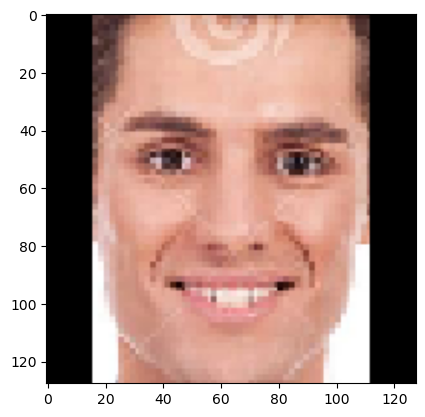

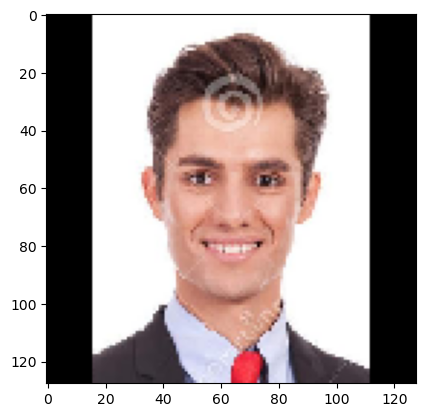

C:\Users\Aaron\AppData\Local\Temp\ipykernel_9804\1727795376.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True) #append the attributes of one face to the dataframe


1_Handshaking_Handshaking_1_134
E:\Downloads\Academic\Year 4 - Second Term\THS-ST2\Face Segmentation Branch\THS-ST1\PyTorch-YOLOv3-master\images\1_Handshaking_Handshaking_1_134.jpg
1_Handshaking_Handshaking_1_134.jpg
Face  0
Cropped
119 81 159 139


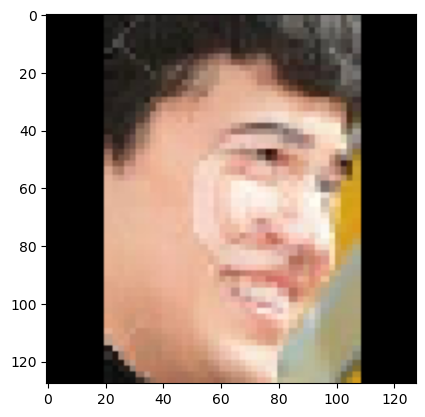

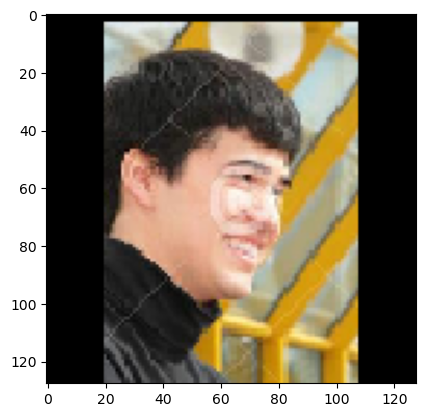

Face  1
Cropped
284 75 320 145


C:\Users\Aaron\AppData\Local\Temp\ipykernel_9804\1727795376.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True) #append the attributes of one face to the dataframe


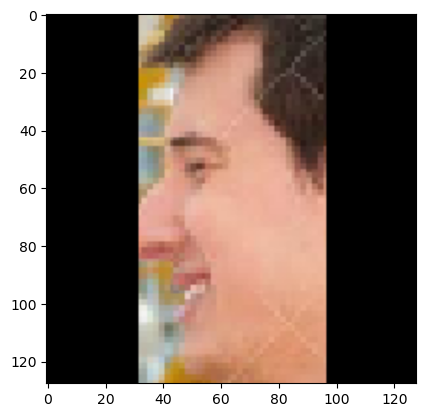

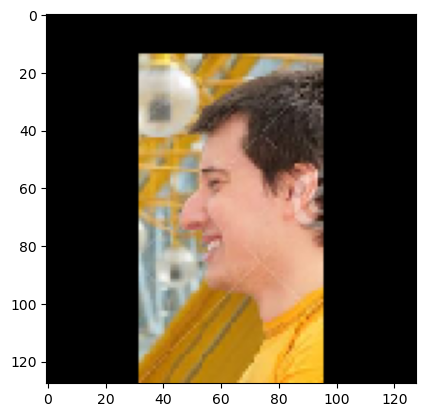

C:\Users\Aaron\AppData\Local\Temp\ipykernel_9804\1727795376.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True) #append the attributes of one face to the dataframe


1_Handshaking_Handshaking_1_158
E:\Downloads\Academic\Year 4 - Second Term\THS-ST2\Face Segmentation Branch\THS-ST1\PyTorch-YOLOv3-master\images\1_Handshaking_Handshaking_1_158.jpg
1_Handshaking_Handshaking_1_158.jpg
Face  0
Cropped
84 117 131 185


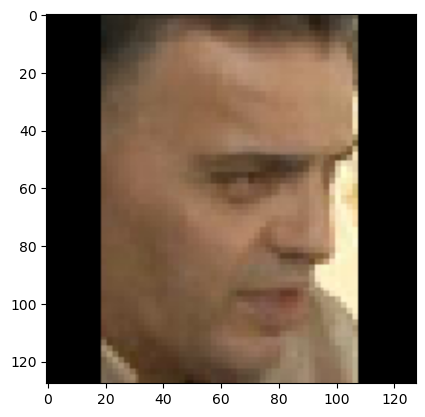

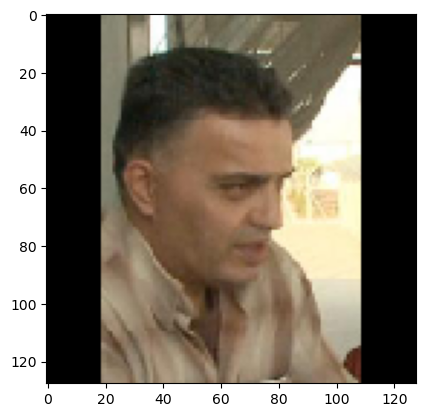

Face  1
Cropped
284 77 334 168


C:\Users\Aaron\AppData\Local\Temp\ipykernel_9804\1727795376.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True) #append the attributes of one face to the dataframe


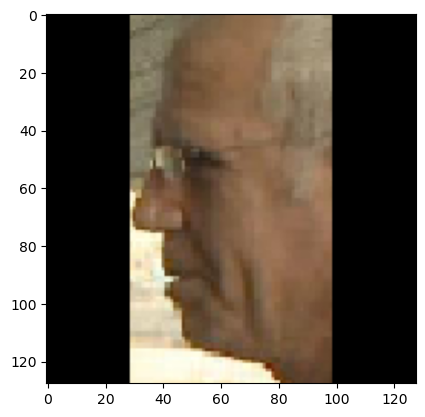

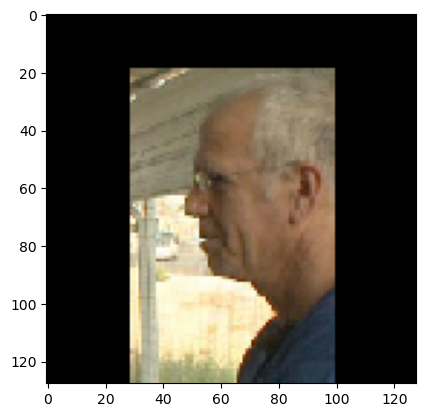

Face  2
Cropped
186 153 217 195


C:\Users\Aaron\AppData\Local\Temp\ipykernel_9804\1727795376.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True) #append the attributes of one face to the dataframe


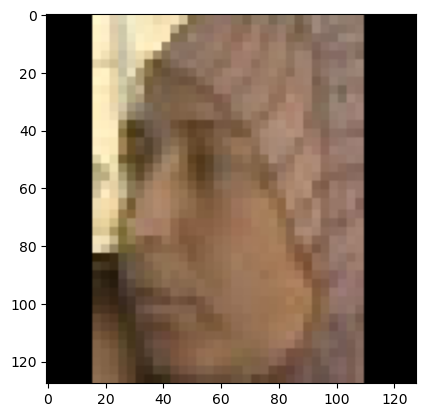

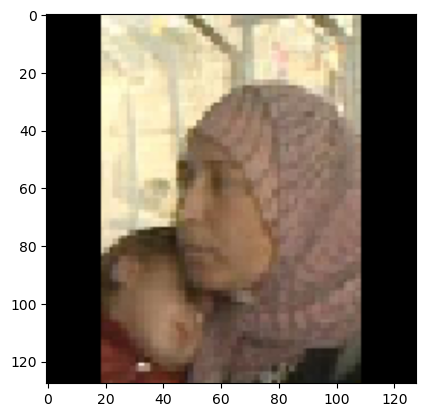

C:\Users\Aaron\AppData\Local\Temp\ipykernel_9804\1727795376.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True) #append the attributes of one face to the dataframe


1_Handshaking_Handshaking_1_35
E:\Downloads\Academic\Year 4 - Second Term\THS-ST2\Face Segmentation Branch\THS-ST1\PyTorch-YOLOv3-master\images\1_Handshaking_Handshaking_1_35.jpg
1_Handshaking_Handshaking_1_35.jpg
Face  0
Cropped
185 35 243 120


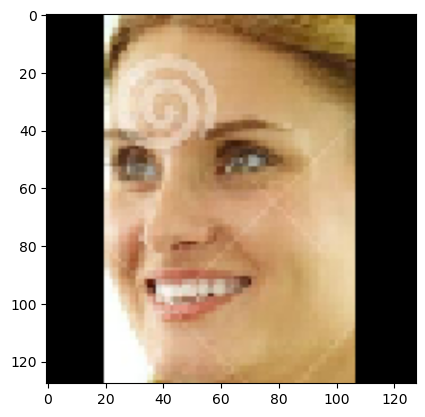

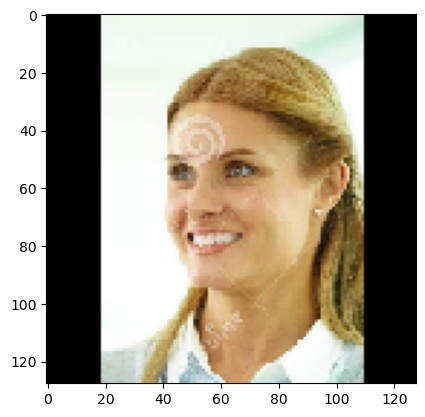

C:\Users\Aaron\AppData\Local\Temp\ipykernel_9804\1727795376.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True) #append the attributes of one face to the dataframe


1_Handshaking_Handshaking_1_94
E:\Downloads\Academic\Year 4 - Second Term\THS-ST2\Face Segmentation Branch\THS-ST1\PyTorch-YOLOv3-master\images\1_Handshaking_Handshaking_1_94.jpg
1_Handshaking_Handshaking_1_94.jpg
Face  0
Cropped
169 70 239 167


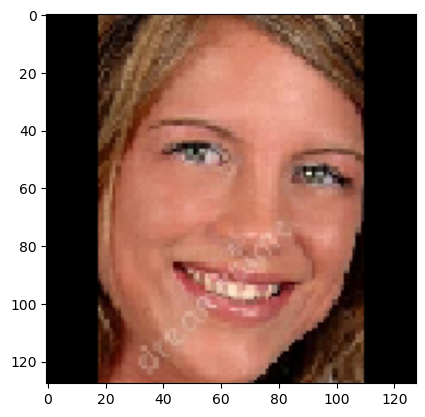

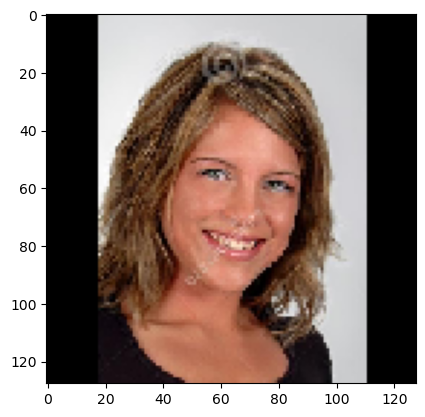

C:\Users\Aaron\AppData\Local\Temp\ipykernel_9804\1727795376.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True) #append the attributes of one face to the dataframe


couple
E:\Downloads\Academic\Year 4 - Second Term\THS-ST2\Face Segmentation Branch\THS-ST1\PyTorch-YOLOv3-master\images\couple.jpg
couple.jpg
Face  0
Cropped
91 158 188 276


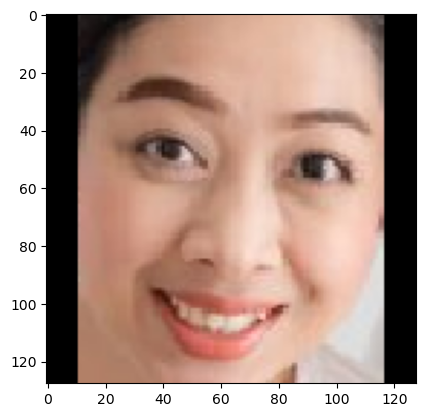

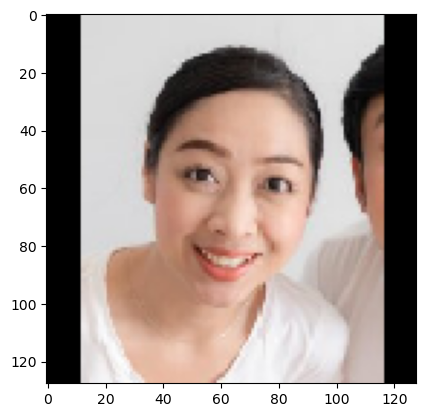

Face  1
Cropped
224 137 322 277


C:\Users\Aaron\AppData\Local\Temp\ipykernel_9804\1727795376.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True) #append the attributes of one face to the dataframe


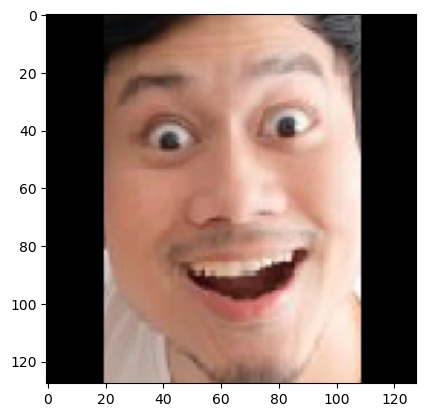

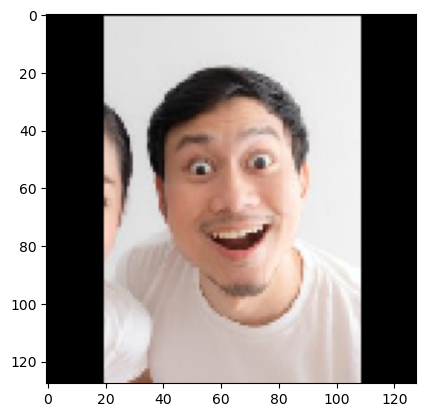

C:\Users\Aaron\AppData\Local\Temp\ipykernel_9804\1727795376.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True) #append the attributes of one face to the dataframe


girl
E:\Downloads\Academic\Year 4 - Second Term\THS-ST2\Face Segmentation Branch\THS-ST1\PyTorch-YOLOv3-master\images\girl.jpg
girl.jpg
Face  0
Cropped
126 129 289 350


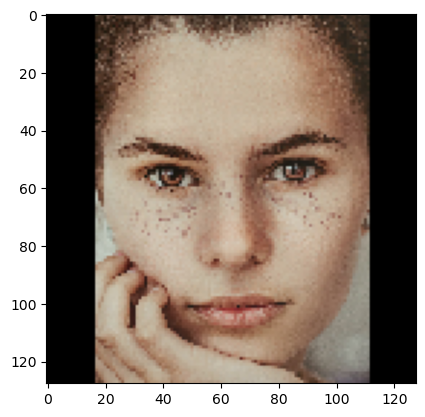

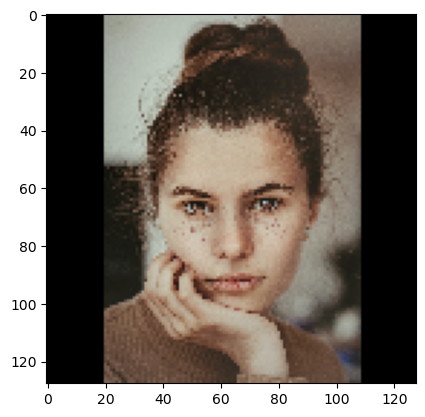

C:\Users\Aaron\AppData\Local\Temp\ipykernel_9804\1727795376.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True) #append the attributes of one face to the dataframe


In [13]:
# [FACE EXTRACTION PART]
pipeline(model, device)

2023-02-22 19:40:17,885 - part_label_dataset - INFO - reading the image files...
2023-02-22 19:40:17,886 - part_label_dataset - INFO - finished initializing the dataloader 11 files.
viz: 0it [00:00, ?it/s]

IMAGE FILENAME IS: 1_Handshaking_Handshaking_1_107_0_image_final.png


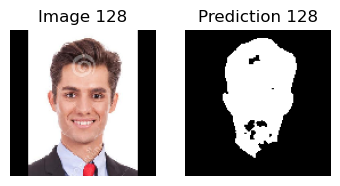

IMAGE FILENAME IS: 1_Handshaking_Handshaking_1_134_0_image_final.png


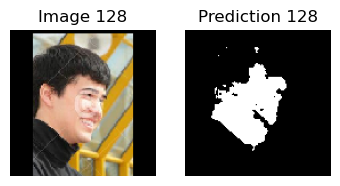

IMAGE FILENAME IS: 1_Handshaking_Handshaking_1_134_1_image_final.png


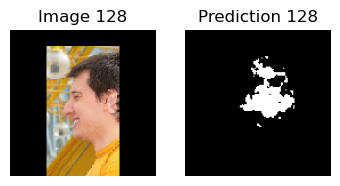

IMAGE FILENAME IS: 1_Handshaking_Handshaking_1_158_0_image_final.png


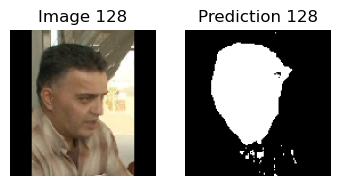

IMAGE FILENAME IS: 1_Handshaking_Handshaking_1_158_1_image_final.png


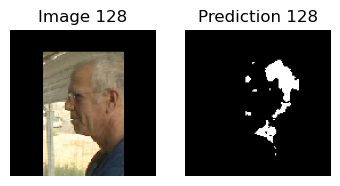

IMAGE FILENAME IS: 1_Handshaking_Handshaking_1_158_2_image_final.png


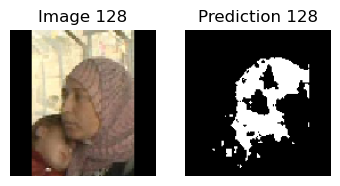

IMAGE FILENAME IS: 1_Handshaking_Handshaking_1_35_0_image_final.png


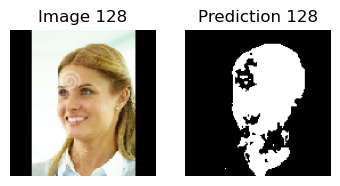

IMAGE FILENAME IS: 1_Handshaking_Handshaking_1_94_0_image_final.png


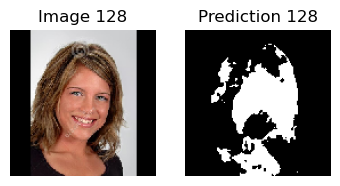

IMAGE FILENAME IS: couple_0_image_final.png


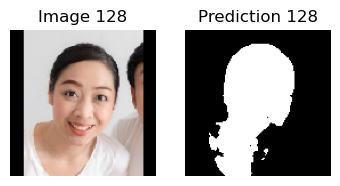

IMAGE FILENAME IS: couple_1_image_final.png


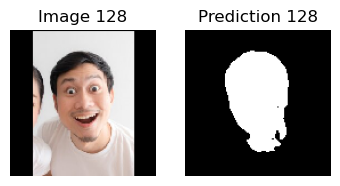

IMAGE FILENAME IS: girl_0_image_final.png


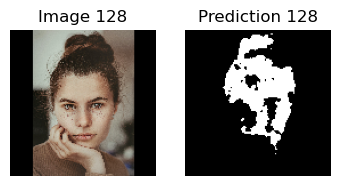

viz: 0it [00:04, ?it/s]


In [14]:
# [FACE SEGMENTATION PART]
eval_dataloader = get_dataloader((eval_path,),
                      batch_size=64,
                      mode='eval', 
                      num_workers = 4,
                      n_classes=3,
                      dataset_name='PartLabel')                        

viz_notebook_brew(fs_model,eval_dataloader,fs_device,ibv_stop=0)       

In [16]:
RESTORED_MASK_PATH = '.\\images_restored_mask'
APPLIED_MASK_PATH = '.\\images_applied_mask'

if not os.path.exists(RESTORED_MASK_PATH):
    os.mkdir(RESTORED_MASK_PATH)
    
if not os.path.exists(APPLIED_MASK_PATH):
    os.mkdir(APPLIED_MASK_PATH)    

# LOAD DATASET
faces_df = pd.read_csv(CSV_PATH + "\\dataset.csv")
pixels_df = pd.DataFrame()
row = {}

# PER MASK FILES IN LOCATION
masks = glob.glob(MASK_PATH + "/*.png")
for mask in masks:
    with open(mask, 'rb') as file:
        # GET THE FILENAME       
        filename = os.path.basename(MASK_PATH + mask)         
        print(filename)
        
        # SET THE RESTORED FILENAME 
        restored_filename = "restored_" + filename                
        row['filename'] = restored_filename    
        
        # MATCH FILENAME WITH DATASET
        face_row = faces_df.loc[faces_df['mask_filename'] == filename]        
        
        # GET THE ORIGINAL SIZE
        x_size = face_row['x2_pad'] - face_row['x1_pad']
        y_size = face_row['y2_pad'] - face_row['y1_pad']        
        greater_size = max(x_size.item(), y_size.item())        
        restored_size = (greater_size, greater_size)                
        
        # OPEN AND PROCESS IMAGE
        img = Image.open(file).convert("RGB")        
        img = img.resize(restored_size)
                    
        img_arr = np.array(img)
        
        # Convert non-black pixels to white
        non_black_pixels_mask = np.any(img_arr != [0, 0, 0], axis=-1)          
        img_arr[non_black_pixels_mask] = [255, 255, 255]                
        
        # CHECK NUMBER OF PIXELS AND UNIQUE VALUES WITH THIS
        # unique, counts = np.unique(img_arr, return_counts=True)
        # print(np.asarray((unique, counts)).T)
        # CHECK UNIQUE VALUES WITH THIS
        # with np.printoptions(threshold=np.inf):
        #     print(img_arr)
                
        # SAVE THE FILE
        sum_img = Image.fromarray(img_arr)
        sum_img = sum_img.save(RESTORED_MASK_PATH + "\\" + restored_filename)
                
        # COUNT PIXELS FASTER ALTERNATIVE
        unique, counts = np.unique(img_arr, return_counts=True)
        total_pixels = np.asarray((unique, counts)).T[1][1] / 3
        
        row['pixels'] = total_pixels
        pixels_df = pixels_df.append(row, ignore_index=True)
                                        
        # MASKING HERE   
        # OPEN THE FILE AND MATCH THE FILENAME 
        img_orig = Image.open(ORIG_PAD_PATH + "\\" + filename)
        img_orig = np.array(img_orig)        
        # Select the location of all black pixels
        black_pixels_mask = np.any(img_arr == [0, 0, 0], axis=-1)
        img_orig[black_pixels_mask] = [0, 0, 0]     
        
        sum_img_orig = Image.fromarray(img_orig)
        sum_img_orig = sum_img_orig.save(APPLIED_MASK_PATH + "\\" + filename)
        
pixels_df.to_csv(os.path.join(CSV_PATH, 'dataset_pixels' + str(int(time.time())) + '.csv'), index=False)  #save to csv        

mask_1_Handshaking_Handshaking_1_107_0_image_final.png
mask_1_Handshaking_Handshaking_1_134_0_image_final.png
mask_1_Handshaking_Handshaking_1_134_1_image_final.png
mask_1_Handshaking_Handshaking_1_158_0_image_final.png
mask_1_Handshaking_Handshaking_1_158_1_image_final.png
mask_1_Handshaking_Handshaking_1_158_2_image_final.png
mask_1_Handshaking_Handshaking_1_35_0_image_final.png
mask_1_Handshaking_Handshaking_1_94_0_image_final.png
mask_couple_0_image_final.png
mask_couple_1_image_final.png
mask_girl_0_image_final.png


C:\Users\Aaron\AppData\Local\Temp\ipykernel_9804\648063817.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pixels_df = pixels_df.append(row, ignore_index=True)
C:\Users\Aaron\AppData\Local\Temp\ipykernel_9804\648063817.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pixels_df = pixels_df.append(row, ignore_index=True)
C:\Users\Aaron\AppData\Local\Temp\ipykernel_9804\648063817.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pixels_df = pixels_df.append(row, ignore_index=True)
C:\Users\Aaron\AppData\Local\Temp\ipykernel_9804\648063817.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pixels_df = pixels_df.append(row, ign